In [1]:
import sys

# RDKit for molecule parsing and drawing
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# IPython for inline visuals
from IPython.display import display, HTML

# We'll assume we have your custom high-level CReM API here
# e.g. "from crem.api import grow, mutate"
# For demonstration, I'll just show a 'mock' or typical usage:

from crem.api import grow, mutate

# Let's confirm RDKit version:
print("RDKit version:", rdkit.__version__)

RDKit version: 2024.03.6


In [4]:
# Point this to your actual fragment DB
db_path = "/Users/thomasgraham/prj/crem/output_uv/fragments.db"  

# Example molecules
smiles_to_mutate = "c1ccccc1C"  # Toluene
smiles_to_grow   = "CC1=C(C(C)=CC=C1)CNC2=NCCN(C2)CC3=CC=CC=N3"

In [5]:
mutated_smiles = mutate(
    mol=smiles_to_mutate,    # "c1ccccc1C"
    db_path=db_path,
    radius=3,
    max_replacements=5,
    ring_only=True,          # we specifically want ring-based replacements
    ncores=1,
)
print("Mutated structures (up to 5 shown):")
for i, smi in enumerate(mutated_smiles[:5], start=1):
    print(f"{i}. {smi}")

Mutated structures (up to 5 shown):
1. O=C(O)c1ccccc1
2. O=[N+]([O-])c1ccccc1
3. CSc1ccccc1
4. Clc1ccccc1
5. Oc1ccccc1


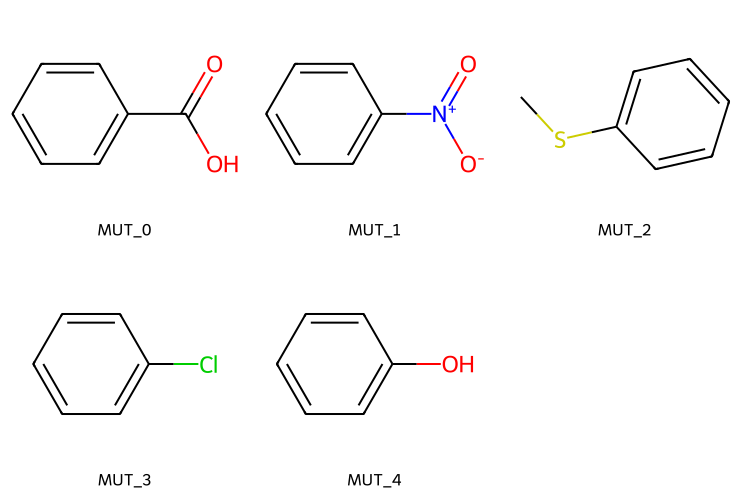

In [6]:
# Convert each SMILES to an RDKit Mol
mutated_mols = [Chem.MolFromSmiles(s) for s in mutated_smiles[:5] if Chem.MolFromSmiles(s)]
Draw.MolsToGridImage(
    mutated_mols,
    molsPerRow=3,
    subImgSize=(250,250),
    legends=[f"MUT_{i}" for i in range(len(mutated_mols))],
)

In [7]:
grown_smiles = grow(
    mol=smiles_to_grow,    # "CCO"
    db_path=db_path,
    radius=2,
    min_atoms=2,
    max_atoms=3,
    max_replacements=5,
    ncores=1,
)
print("\nGrown structures (up to 5 shown):")
for i, smi in enumerate(grown_smiles[:5], start=1):
    print(f"{i}. {smi}")


Grown structures (up to 5 shown):
1. Cc1cccc(C)c1CNC1=NCCN(C(C(=O)O)c2ccccn2)C1
2. CSc1ccc(CN2CCN=C(NCc3c(C)cccc3C)C2)nc1
3. CCOc1cc(C)c(CNC2=NCCN(Cc3ccccn3)C2)c(C)c1
4. Cc1cccc(C)c1CNC1=NCC(C(=O)O)N(Cc2ccccn2)C1
5. Cc1cccc(CC(=O)O)c1CNC1=NCCN(Cc2ccccn2)C1


[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:30:53] WARNING: not removing hydrogen atom with dummy atom neighbors


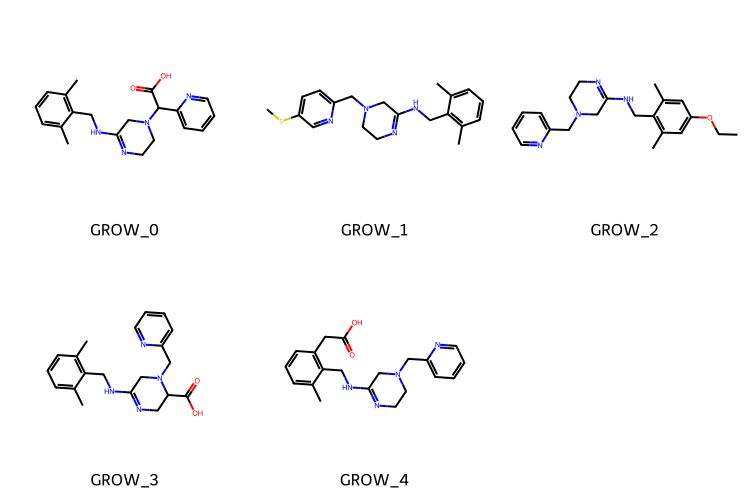

In [8]:
grown_mols = [Chem.MolFromSmiles(s) for s in grown_smiles[:5] if Chem.MolFromSmiles(s)]
Draw.MolsToGridImage(
    grown_mols,
    molsPerRow=3,
    subImgSize=(250,250),
    legends=[f"GROW_{i}" for i in range(len(grown_mols))],
)

You can integrate these steps into your custom pipelines, or your own scripts. If you have many molecules, you can call them in a loop or with your favorite parallelization mechanism. The high-level mutate and grow functions from crem.api provide a simplified usage interface over the lower-level building blocks in crem.core.

Remember, if your DB does not contain ring fragments or side-chain expansions matching the environment, you might see no results or minimal results. Or you might see warnings like:

```bash
WARNING: not removing hydrogen atom with dummy atom neighbors
```

Example: Seeing No Output?

If you get no output for mutation or growth, it often means your fragment DB lacks relevant fragments. For instance, if your DB was built from small aliphatic molecules only, and you try to mutate a complicated ring system, CReM can’t find matching ring fragments. That’s normal. You’d need a fragment DB with ring moieties.c

In [10]:
import ipywidgets as widgets
from ipywidgets import interact

@interact(
    radius=widgets.IntSlider(min=1, max=5, step=1, value=3),
    max_replacements=widgets.IntSlider(min=1, max=50, step=1, value=5),
    ring_only=widgets.Checkbox(value=True, description="Ring Only?"),
)
def interactive_mutate(radius, max_replacements, ring_only):
    mutated_smis = mutate(smiles_to_mutate, db_path, radius=radius,
                          max_replacements=max_replacements,
                          ring_only=ring_only)
    mutated_mols = [Chem.MolFromSmiles(s) for s in mutated_smis[:6]]
    return Draw.MolsToGridImage(mutated_mols, molsPerRow=10, subImgSize=(250,250))

interactive(children=(IntSlider(value=3, description='radius', max=5, min=1), IntSlider(value=5, description='…

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from ipywidgets import interact
import ipywidgets as widgets

@interact(
    radius=widgets.IntSlider(value=3, min=1, max=5, step=1, description='Radius'),
    min_atoms=widgets.IntSlider(value=1, min=1, max=5, step=1, description='Min new atoms'),
    max_atoms=widgets.IntSlider(value=3, min=1, max=10, step=1, description='Max new atoms'),
    max_replacements=widgets.IntSlider(value=5, min=1, max=50, step=1, description='Max repl'),
    ncores=widgets.IntText(value=1, description='CPU cores')
)
def interactive_grow(radius, min_atoms, max_atoms, max_replacements, ncores):
    """
    Interactive widget to 'grow' a molecule by replacing hydrogens with fragments
    from the CReM DB, then display them in a small grid of images.
    """
    grown_smiles_list = grow(
        mol=smiles_to_grow,
        db_path=db_path,
        radius=radius,
        min_atoms=min_atoms,
        max_atoms=max_atoms,
        max_replacements=max_replacements,
        ncores=ncores,
    )

    if not grown_smiles_list:
        return "No results found. Possibly the database has no matching fragments."

    # Convert each grown result into an RDKit Mol
    grown_mols = []
    for smi in grown_smiles_list[:9]:  # limit to 9 expansions
        m = Chem.MolFromSmiles(smi)
        if m:
            AllChem.Compute2DCoords(m)
            grown_mols.append(m)

    # Optional: Show original molecule first in the list if you want
    orig_mol = Chem.MolFromSmiles(smiles_to_grow)
    AllChem.Compute2DCoords(orig_mol)

    # Setup the drawing options:
    dopts = rdMolDraw2D.MolDrawOptions()  # CORRECT instead of "Draw.rdDepictor.DefaultDrawingOptions()"
    dopts.bondLineWidth = 2.5
    dopts.minFontSize = 14
    dopts.highlightRadius = 0.4
    # ... add more if needed

    # Combine original + grown in one list
    all_mols = [orig_mol] + grown_mols
    legends = ["Original"] + [f"GROW_{i}" for i in range(len(grown_mols))]

    # Render them in a grid
    img = Draw.MolsToGridImage(
        all_mols,
        molsPerRow=3,
        subImgSize=(350, 350),
        legends=legends,
        drawOptions=dopts,
    )
    return img

interactive(children=(IntSlider(value=3, description='Radius', max=5, min=1), IntSlider(value=1, description='…

# Key Variables in the interactive_grow Widget

## 1. start_smi (start_smi = "CCO")
- Starting molecule (SMILES) for growth via hydrogen replacement with fragments
- Tiny molecules allow quick functional group/ring additions
- Larger molecules offer more growth points, subject to constraints

## 2. db_path ("fragments.db") 
- Path to CReM fragment database containing context-fragment pairs
- Richer DB yields more diverse outputs
- Limited DB produces fewer/restricted transformations

## 3. radius (value=3, min=1, max=5)
- Bonds considered around attachment point for molecular context
- Smaller radius (1): More permissive matching, more replacements but potentially less valid
- Larger radius (4-5): Fewer but more chemically consistent transformations

## 4. min_atoms
- Minimum heavy atoms in replacing fragment
- Lower: Allows simpler groups (methyl)
- Higher: Enforces bigger additions (ethyl, propyl, rings)

## 5. max_atoms
- Maximum heavy atoms in replacing fragment
- Low (2): Only small substituents
- High (10-12): Enables ring systems/large functional groups

## 6. max_replacements
- Maximum new substituents per grow() call
- Small (5): Manageable output set
- High (50): More structures but slower, potential duplicates

## 7. ncores
- CPU cores for parallel processing
- Multi-core machines: Higher values speed up large DB searches
- Typical range: 4-8 cores

# Effect of Parameter Changes

## Radius Changes
### Increasing
- More specific environment
- Fewer but better-fitting matches
- Requires rich DB for higher contexts

### Decreasing
- Less specific environment
- More creative expansions
- May reduce synthetic plausibility

## Size Constraints
- Higher max_atoms: Enables rings/multi-branch substituents
- Lower max_atoms (1-3): Restricts to small substituents

## Optimization Notes
- max_replacements controls output volume
- ncores affects processing speed
- Context radius (1-3) typical for test scenarios
- Synthetic feasibility improved by:
 - Common DB fragments
 - Larger radius
 - Size restrictions

# Usage Guidelines

1. Radius Adjustment
  - Smaller: More expansions, looser matching
  - Larger: Fewer expansions, stricter matching

2. Atom Limits
  - Increase for structural expansions
  - Decrease for simple substituents

3. Replacements
  - Increase for broader exploration
  - Decrease for focused results

4. CPU Optimization
  - Scale with DB size and query complexity